In [ ]:
# globally useful imports of standard libraries needed in this notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path
from datetime import datetime

# specific libraries or classes needed for the work in this notebook
#from sklearn.linear_model import LogisticRegression
#from sklearn.linear_model import LogisticRegressionCV
#from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif, chi2, SelectFpr, f_regression, mutual_info_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.pipeline import Pipeline
# need to use Pipeline from imblearn to add in a downsample or upsample
# to cross validation training
from imblearn.pipeline import Pipeline

# import project specific modules used in this notebook
import sys
sys.path.append('../src')
import mindwandering.data
import mindwandering.features
import mindwandering.evaluate
from mindwandering.data import FeatureScalerTransformer
from mindwandering.data import WinsorizationOutlierTransformer
from mindwandering.data import VIFThresholdTransformer
from mindwandering.data import FeatureSelectionTransformer
from mindwandering.data import ClassImbalanceTransformer
from mindwandering.data import GridSearchProgressHack

In [2]:
# Load Data and Features
df_features = mindwandering.data.get_df_features()
mind_wandered_label = mindwandering.data.get_mind_wandered_label()
participant_ids = mindwandering.data.get_participant_ids()

# vif thresholds to apply to data and labels before grid search pipeline
#vif_thresholds = [0, 5]
vif_thresholds = [0]

# we want to actually select a certain percentage of features of whatever remains
# after vif thresholding.  So we will calculate these in the loop based on the number
# of features in data, and add to the parameters dictionary before the grid search
#features__k_ratios = np.array([0.25, 0.5, 0.75, 1.0])
features__k_ratios = np.array([0.2, 0.25, 0.3, 0.35, 0.4, 0.5])

# Empty dataframe to gather grid search results into 1 place
best_estimator = None
best_score = 0.0
best_params = {}
best_index = 0
df_result = None

# search over vif threshold meta parameters, create separate df from vif_threshold
# for otherwise identical grid searches
for vif_threshold in vif_thresholds:
    # display progress
    print('')
    print('=' * 50)
    print('Starting vif meta-parameter condition: vif_threshold: ', vif_threshold)
    
    # pipeline to apply vif threshold selection
    vif_pipeline = Pipeline(
      [
        ('vif',      VIFThresholdTransformer(score_threshold=vif_threshold)),
      ]
    )
 
    df_vif_features = vif_pipeline.transform(df_features)
    num_trials, num_features = df_vif_features.shape
    print('   Number of trials: ', num_trials, ' Number of Features: ', num_features)
    
    parameters = {
        'scaling__type_of_scaling': ['standard'],
        'outlier__outlier_threshold': [0.0, 3.0],
        'features__score_func': [f_classif],
        #'balance__balancer_type': ['random-undersampler', 'allknn', 'nearmiss', 'instance-hardness-threshold'],
        #'balance__balancer_type': ['allknn', 'condensed-nn', 'neighbourhood-cleaning', 'one-sided-selection'],
        #'balance__balancer_type': ['allknn', 'one-sided-selection'],
        'balance__balancer_type': ['allknn', 'smote-enn'],
        'model__criterion': ['gini','entropy'],
        'model__max_depth':np.arange(3,10).tolist(),
        'model__max_leaf_nodes':np.arange(3,10).tolist()
    }

    # set feature selection k correctly
    features__k = features__k_ratios * num_features
    features__k = features__k.astype(int) 
    parameters['features__k'] = features__k.tolist()

    # Estimator Pipeline
    pipeline = Pipeline(
      [
        ('progress', GridSearchProgressHack(verbose=False)),
        ('scaling',  FeatureScalerTransformer()),
        ('outlier',  WinsorizationOutlierTransformer()),
        ('features', SelectKBest()),
        #('features', SelectFromModel(estimator=LogisticRegression(solver='liblinear', penalty='l1', C=0.1), threshold=-np.inf)),
        ('balance',  ClassImbalanceTransformer()),
        ('model',    DecisionTreeClassifier(random_state=0)),
      ]
    )
    
    # Cross Validation Splitter
    cv_group_splitter = GroupKFold(n_splits=5)
    #cv_group_splitter = LeaveOneGroupOut()

    # perform the grid search for this vif selection
    # set up the search
    search = GridSearchCV(
        estimator = pipeline,
        param_grid = parameters,
        scoring = ['roc_auc', 'accuracy'],
        cv = cv_group_splitter,
        refit = 'roc_auc',
        verbose = 1
    )
    search.fit(df_vif_features, mind_wandered_label, groups=participant_ids)
    
    # append results onto the dataframe collecting the results.  Need to add
    # a feature column to this dataframe for the vif vit condition here
    df = pd.DataFrame(data=search.cv_results_)
    df['param__vif_score_threshold'] = vif_threshold
    
    if best_estimator is None:
        df_result = df
        best_estimator = search.best_estimator_
        best_score = search.best_score_
        best_params = search.best_params_
        best_index = search.best_index_
    else:
        df_result = df_result.append(df, ignore_index=True)
        if search.best_score_ > best_score:
            best_estimator = search.best_estimator_
            best_score = search.best_score_
            best_params = search.best_params_
            best_index = search.best_index_  # todo this is only the index of this search
            



Starting vif meta-parameter condition: vif_threshold:  0
   Number of trials:  4076  Number of Features:  62
Fitting 5 folds for each of 2352 candidates, totalling 11760 fits


0001 0002 0003 0004 0005 0006 0007 0008 0009 0010 0011 0012 0013 0014 0015 0016 0017 0018 0019 0020 0021 0022 0023 0024 0025 0026 0027 0028 0029 0030 0031 0032 0033 0034 0035 0036 0037 0038 0039 0040 0041 0042 0043 0044 0045 0046 0047 0048 0049 0050 0051 0052 0053 0054 0055 0056 0057 0058 0059 0060 0061 0062 0063 0064 0065 0066 0067 0068 0069 0070 0071 0072 0073 0074 0075 0076 0077 0078 0079 0080 0081 0082 0083 0084 0085 0086 0087 0088 0089 0090 0091 0092 0093 0094 0095 0096 0097 0098 0099 0100 0101 0102 0103 0104 0105 0106 0107 0108 0109 0110 0111 0112 0113 0114 0115 0116 0117 0118 0119 0120 0121 0122 0123 0124 0125 0126 0127 0128 0129 0130 0131 0132 0133 0134 0135 0136 0137 0138 0139 0140 0141 0142 0143 0144 0145 0146 0147 0148 0149 0150 0151 0152 0153 0154 0155 0156 0157 0158 0159 0160 0161 0162 0163 0164 0165 0166 0167 0168 0169 0170 0171 0172 0173 0174 0175 0176 0177 0178 0179 0180 0181 0182 0183 0184 0185 0186 0187 0188 0189 0190 0191 0192 0193 0194 0195 0196 0197 0198 0199 0200 

3279 3280 3281 3282 3283 3284 3285 3286 3287 3288 3289 3290 3291 3292 3293 3294 3295 3296 3297 3298 3299 3300 3301 3302 3303 3304 3305 3306 3307 3308 3309 3310 3311 3312 3313 3314 3315 3316 3317 3318 3319 3320 3321 3322 3323 3324 3325 3326 3327 3328 3329 3330 3331 3332 3333 3334 3335 3336 3337 3338 3339 3340 3341 3342 3343 3344 3345 3346 3347 3348 3349 3350 3351 3352 3353 3354 3355 3356 3357 3358 3359 3360 3361 3362 3363 3364 3365 3366 3367 3368 3369 3370 3371 3372 3373 3374 3375 3376 3377 3378 3379 3380 3381 3382 3383 3384 3385 3386 3387 3388 3389 3390 3391 3392 3393 3394 3395 3396 3397 3398 3399 3400 3401 3402 3403 3404 3405 3406 3407 3408 3409 3410 3411 3412 3413 3414 3415 3416 3417 3418 3419 3420 3421 3422 3423 3424 3425 3426 3427 3428 3429 3430 3431 3432 3433 3434 3435 3436 3437 3438 3439 3440 3441 3442 3443 3444 3445 3446 3447 3448 3449 3450 3451 3452 3453 3454 3455 3456 3457 3458 3459 3460 3461 3462 3463 3464 3465 3466 3467 3468 3469 3470 3471 3472 3473 3474 3475 3476 3477 3478 

4918 4919 4920 4921 4922 4923 4924 4925 4926 4927 4928 4929 4930 4931 4932 4933 4934 4935 4936 4937 4938 4939 4940 4941 4942 4943 4944 4945 4946 4947 4948 4949 4950 4951 4952 4953 4954 4955 4956 4957 4958 4959 4960 4961 4962 4963 4964 4965 4966 4967 4968 4969 4970 4971 4972 4973 4974 4975 4976 4977 4978 4979 4980 4981 4982 4983 4984 4985 4986 4987 4988 4989 4990 4991 4992 4993 4994 4995 4996 4997 4998 4999 5000 5001 5002 5003 5004 5005 5006 5007 5008 5009 5010 5011 5012 5013 5014 5015 5016 5017 5018 5019 5020 5021 5022 5023 5024 5025 5026 5027 5028 5029 5030 5031 5032 5033 5034 5035 5036 5037 5038 5039 5040 5041 5042 5043 5044 5045 5046 5047 5048 5049 5050 5051 5052 5053 5054 5055 5056 5057 5058 5059 5060 5061 5062 5063 5064 5065 5066 5067 5068 5069 5070 5071 5072 5073 5074 5075 5076 5077 5078 5079 5080 5081 5082 5083 5084 5085 5086 5087 5088 5089 5090 5091 5092 5093 5094 5095 5096 5097 5098 5099 5100 5101 5102 5103 5104 5105 5106 5107 5108 5109 5110 5111 5112 5113 5114 5115 5116 5117 

6557 6558 6559 6560 6561 6562 6563 6564 6565 6566 6567 6568 6569 6570 6571 6572 6573 6574 6575 6576 6577 6578 6579 6580 6581 6582 6583 6584 6585 6586 6587 6588 6589 6590 6591 6592 6593 6594 6595 6596 6597 6598 6599 6600 6601 6602 6603 6604 6605 6606 6607 6608 6609 6610 6611 6612 6613 6614 6615 6616 6617 6618 6619 6620 6621 6622 6623 6624 6625 6626 6627 6628 6629 6630 6631 6632 6633 6634 6635 6636 6637 6638 6639 6640 6641 6642 6643 6644 6645 6646 6647 6648 6649 6650 6651 6652 6653 6654 6655 6656 6657 6658 6659 6660 6661 6662 6663 6664 6665 6666 6667 6668 6669 6670 6671 6672 6673 6674 6675 6676 6677 6678 6679 6680 6681 6682 6683 6684 6685 6686 6687 6688 6689 6690 6691 6692 6693 6694 6695 6696 6697 6698 6699 6700 6701 6702 6703 6704 6705 6706 6707 6708 6709 6710 6711 6712 6713 6714 6715 6716 6717 6718 6719 6720 6721 6722 6723 6724 6725 6726 6727 6728 6729 6730 6731 6732 6733 6734 6735 6736 6737 6738 6739 6740 6741 6742 6743 6744 6745 6746 6747 6748 6749 6750 6751 6752 6753 6754 6755 6756 

8196 8197 8198 8199 8200 8201 8202 8203 8204 8205 8206 8207 8208 8209 8210 8211 8212 8213 8214 8215 8216 8217 8218 8219 8220 8221 8222 8223 8224 8225 8226 8227 8228 8229 8230 8231 8232 8233 8234 8235 8236 8237 8238 8239 8240 8241 8242 8243 8244 8245 8246 8247 8248 8249 8250 8251 8252 8253 8254 8255 8256 8257 8258 8259 8260 8261 8262 8263 8264 8265 8266 8267 8268 8269 8270 8271 8272 8273 8274 8275 8276 8277 8278 8279 8280 8281 8282 8283 8284 8285 8286 8287 8288 8289 8290 8291 8292 8293 8294 8295 8296 8297 8298 8299 8300 8301 8302 8303 8304 8305 8306 8307 8308 8309 8310 8311 8312 8313 8314 8315 8316 8317 8318 8319 8320 8321 8322 8323 8324 8325 8326 8327 8328 8329 8330 8331 8332 8333 8334 8335 8336 8337 8338 8339 8340 8341 8342 8343 8344 8345 8346 8347 8348 8349 8350 8351 8352 8353 8354 8355 8356 8357 8358 8359 8360 8361 8362 8363 8364 8365 8366 8367 8368 8369 8370 8371 8372 8373 8374 8375 8376 8377 8378 8379 8380 8381 8382 8383 8384 8385 8386 8387 8388 8389 8390 8391 8392 8393 8394 8395 

9835 9836 9837 9838 9839 9840 9841 9842 9843 9844 9845 9846 9847 9848 9849 9850 9851 9852 9853 9854 9855 9856 9857 9858 9859 9860 9861 9862 9863 9864 9865 9866 9867 9868 9869 9870 9871 9872 9873 9874 9875 9876 9877 9878 9879 9880 9881 9882 9883 9884 9885 9886 9887 9888 9889 9890 9891 9892 9893 9894 9895 9896 9897 9898 9899 9900 9901 9902 9903 9904 9905 9906 9907 9908 9909 9910 9911 9912 9913 9914 9915 9916 9917 9918 9919 9920 9921 9922 9923 9924 9925 9926 9927 9928 9929 9930 9931 9932 9933 9934 9935 9936 9937 9938 9939 9940 9941 9942 9943 9944 9945 9946 9947 9948 9949 9950 9951 9952 9953 9954 9955 9956 9957 9958 9959 9960 9961 9962 9963 9964 9965 9966 9967 9968 9969 9970 9971 9972 9973 9974 9975 9976 9977 9978 9979 9980 9981 9982 9983 9984 9985 9986 9987 9988 9989 9990 9991 9992 9993 9994 9995 9996 9997 9998 9999 10000 10001 10002 10003 10004 10005 10006 10007 10008 10009 10010 10011 10012 10013 10014 10015 10016 10017 10018 10019 10020 10021 10022 10023 10024 10025 10026 10027 10028 1

11228 11229 11230 11231 11232 11233 11234 11235 11236 11237 11238 11239 11240 11241 11242 11243 11244 11245 11246 11247 11248 11249 11250 11251 11252 11253 11254 11255 11256 11257 11258 11259 11260 11261 11262 11263 11264 11265 11266 11267 11268 11269 11270 11271 11272 11273 11274 11275 11276 11277 11278 11279 11280 11281 11282 11283 11284 11285 11286 11287 11288 11289 11290 11291 11292 11293 11294 11295 11296 11297 11298 11299 11300 11301 11302 11303 11304 11305 11306 11307 11308 11309 11310 11311 11312 11313 11314 11315 11316 11317 11318 11319 11320 11321 11322 11323 11324 11325 11326 11327 11328 11329 11330 11331 11332 11333 11334 11335 11336 11337 11338 11339 11340 11341 11342 11343 11344 11345 11346 11347 11348 11349 11350 11351 11352 11353 11354 11355 11356 11357 11358 11359 11360 11361 11362 11363 11364 11365 11366 11367 11368 11369 11370 11371 11372 11373 11374 11375 11376 11377 11378 11379 11380 11381 11382 11383 11384 11385 11386 11387 11388 11389 11390 11391 11392 11393 1139

In [3]:
# top 20 performers by the test_roc_auc score
#,'param_model__max_features'
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#res_cols = ['mean_test_roc_auc', 'mean_test_accuracy', 'param_balance__balancer_type', 'param_features__k', 
#            'param_features__score_func', 'param_model__C', 'param_model__solver', 
#            'param_outlier__outlier_threshold', 'param__vif_score_threshold']
res_cols = ['mean_test_roc_auc', 'mean_test_accuracy', 'param_balance__balancer_type',
            'param_features__k', 'param_model__criterion', 'param_model__max_depth','param_model__max_leaf_nodes',
            'param_outlier__outlier_threshold']
df_sorted = df_result[res_cols].reset_index(drop=True).sort_values('mean_test_roc_auc', axis=0, ascending=False)
df_sorted.index = pd.RangeIndex(1, len(df_sorted.index)+1)
df_sorted

,mean_test_roc_auc,mean_test_accuracy,param_balance__balancer_type,param_features__k,param_model__criterion,param_model__max_depth,param_model__max_leaf_nodes,param_outlier__outlier_threshold
1,0.640888,0.544918,allknn,15,gini,9,9,0
2,0.640888,0.544918,allknn,15,gini,8,9,0
3,0.640888,0.544918,allknn,15,gini,7,9,0
4,0.640888,0.544918,allknn,15,gini,6,9,0
5,0.639691,0.539038,allknn,15,gini,6,7,0
6,0.639691,0.539038,allknn,15,gini,9,7,0
7,0.639691,0.539038,allknn,15,gini,8,7,0
8,0.639691,0.539038,allknn,15,gini,7,7,0
9,0.639613,0.544673,allknn,15,gini,9,8,0
10,0.639613,0.544673,allknn,15,gini,8,8,0


In [4]:
# the average roc-auc and accuracy scores of just completed search.
# these are the averages of each model over the convolution folds.
#print(df_result['mean_test_roc_auc'])
#print(df_result['mean_test_accuracy'])
print(best_params)

{'balance__balancer_type': 'allknn', 'features__k': 15, 'features__score_func': <function f_classif at 0x7ff668f71e50>, 'model__criterion': 'gini', 'model__max_depth': 6, 'model__max_leaf_nodes': 9, 'outlier__outlier_threshold': 0.0, 'scaling__type_of_scaling': 'standard'}


Accuracy score:         0.6032875368007851
Recall (TPR) score:     0.6783468104222821
Precision score:        0.37487586891757696
AUC-ROC score:          0.6267198108810701

True positives:   755
True negatives:   1704
False positives:  1259
False negatives:  358
True Positive Rate (recall):  0.6783468104222821
False Positive Rate:          0.42490718866014177
Specificity:                  0.5750928113398582

[[1704 1259]
 [ 358  755]]


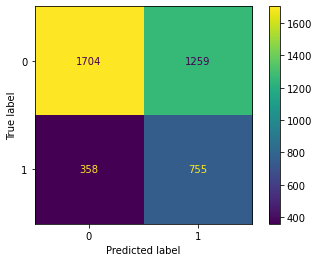

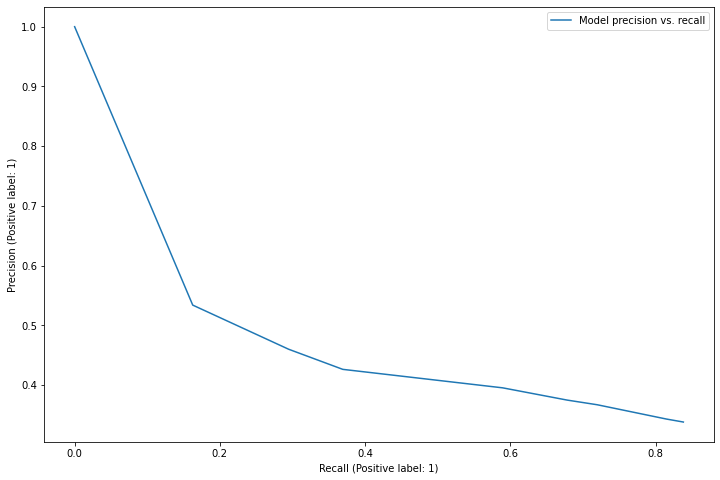

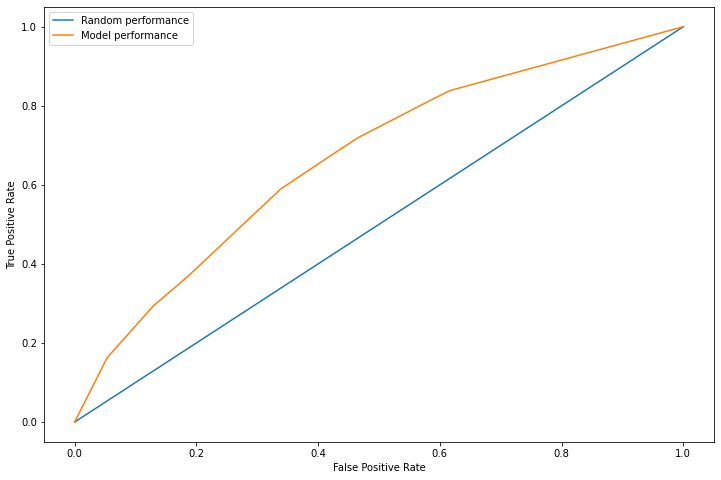

In [5]:
# display results for the best estimator we found
predictions = best_estimator.predict(df_features)
probabilities = best_estimator.predict_proba(df_features)[:,1]
mindwandering.evaluate.evaluate_model_results(mind_wandered_label, predictions, probabilities)

In [6]:
# save the results and preliminary figures in the following cells

# create base save file name for this file, use datetime to keep a unique file name
now = datetime.now()
date_time = now.strftime('%Y%m%d-%H%M')
result_file_basename = 'replication-05-Decision-tree-' + date_time
print(result_file_basename)

replication-05-Decision-tree-20210414-2020


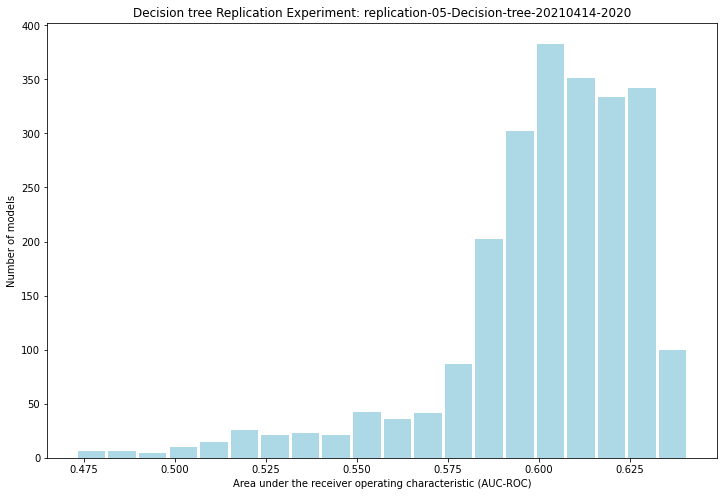

In [7]:
# A quick histogram of this search auc-roc scores.  Basically the figure 1 from the paper.
plt.figure(figsize=(12,8))

#bins = np.linspace(0.605, 0.612, 8)
plt.hist(df_result.mean_test_roc_auc, 
         bins=20,
         color='lightblue',
         rwidth=0.9);
plt.xlabel('Area under the receiver operating characteristic (AUC-ROC)');
plt.ylabel('Number of models');
plt.title('Decision tree Replication Experiment: ' + result_file_basename);

result_dir = '../figures'
result_file_name = result_file_basename + '.eps'
result_file_path = os.path.join(result_dir, result_file_name)
plt.savefig(result_file_path)

In [8]:
# save the search results dataframe to a file so can retrieve for later data analysis or
# to combine with other grid search results for summaries
result_dir = '../results'
result_file_name = result_file_basename + '.pkl'
result_file_path = os.path.join(result_dir, result_file_name)
df_result.to_pickle(result_file_path)